<a href="https://colab.research.google.com/github/mwelland/ENGPYHS_3NM4/blob/main/Optimization_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goals:
- Understand the goal and constraints of optimization
- Identify the differences between optimization and root-finding
- Be able to use 1D bracketted optimization routines (Brent's method)
- Be able to use the ND Powel's method

#Optimization
Optimzation asks us to:

Find $x$ that minimizes $f(\vec{x}$) subject to $\vec{g}(\vec{x}) = 0$ and $\vec{h}(\vec{x})\ge 0$

* $f$ is the *objective* function and typically a scalar
* $\vec{g}(\vec{x})$ is a list of *equality constraints*
* $\vec{h}(\vec{x})$ is a list of *inequality constraints*
* Maximization for $f$ is mearly minimization of $-f$.
* Optimization differs from root finding in the constraints and smoothness of $f$.

We saw with root finding that using gradient information to help search algorithms has important benefits. That remains true in optimization, but since they are often *high dimensional* ($\vec{x}$ is a large vector), and $f$ is not necessarily *well behaved*, great value is placed on methods that do not require (direct) gradient / Hessian calculations.

##Local vs Global minima


Even in 1D, optimization is confounded by *local minimima*. The lowest of the local minima is the *global minimum*.

There is no good way to ensure a local minimia is a global one without calculating and comparing them all!

There are lots of algorithms that attempt to find the global minimum. They either:
* launch multiple minimizers over the range of arguments
* typically involve preturbing *good* solutions in an attempt to escape from local minima basins.

Interestingly, many of these methods are modelled after nature! (Why?)
* Genetic algorithms - mutations, cross-overs, selection)
* Simulated annealing - metalurgical process that accepts worse solutions)
* Partical swarm - Mimics swarming behaviour to track multiple solutions
* Amoeba search (which we will talk about)

Introduction of constraints can further complicate things since sometimes the minimima is at a bound!

#### Example: local and global minimima

Minimize $f = x^2 - cos(5 x)$

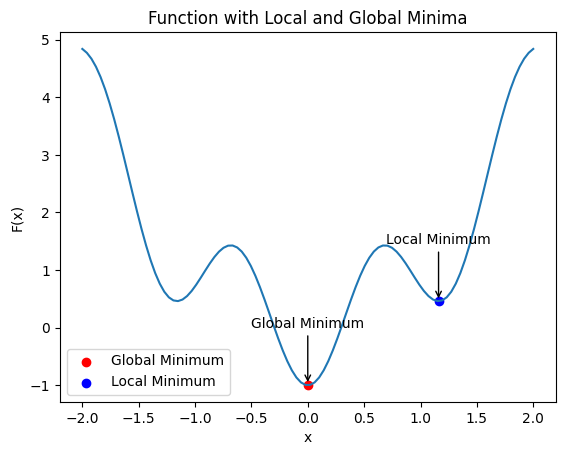

In [ ]:
# prompt: Draw a function with a clear local and global minima, labelled

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

x = np.linspace(-2, 2, 100)
f = lambda x: x**2 + -np.cos(5 * x)
y = f(x)

plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("F(x)")
plt.title("Function with Local and Global Minima")

# Annotate the global minimum
plt.scatter(0, np.min(y), color='red', label='Global Minimum')
plt.annotate('Global Minimum', xy=(0, np.min(y)), xytext=(0, np.min(y) + 1), ha='center', arrowprops=dict(arrowstyle='->'))

# Annotate a local minimum (approximately)
opt =  sp.optimize.minimize(f,1)
local_min_x = opt.x
local_min_y = opt.fun
plt.scatter(local_min_x, local_min_y, color='blue', label='Local Minimum')
plt.annotate('Local Minimum', xy=(local_min_x, local_min_y), xytext=(local_min_x, local_min_y + 1), ha='center', arrowprops=dict(arrowstyle='->'))

plt.legend()
plt.show()


#### Example: Eggholder surfaces

Minimize $y \cdot sin(\sqrt{\|x + y\|}) + x \cdot sin(\sqrt{\|x - y\|})$

In [ ]:
11# prompt: Draw a 2D eggholder surface using plotly

import plotly.graph_objects as go
import numpy as np

def eggholder(x, y):
  return y* np.sin(np.sqrt(abs(x + y ))) + x * np.sin(np.sqrt(abs(x - y)))


x = np.linspace(-512, 512, 100)
y = np.linspace(-512, 512, 100)
X, Y = np.meshgrid(x, y)
Z = eggholder(X, Y)/10

fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y)])
fig.update_layout(title='Eggholder Function', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()


#### Example: Constrained minimization

Minimize $x^2+x$ such that $\|x\| \le 1$

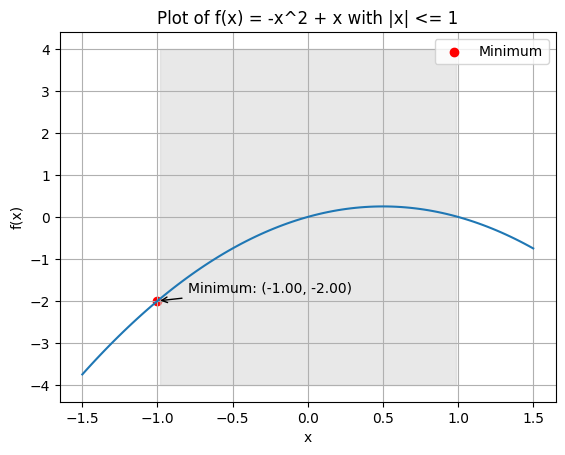

In [ ]:
# prompt: Plot -x^2+x and find the minimum with |x|\le 1 and show the minimium

import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as optimize

# Define the function
def f(x):
  return -x**2 + x

# Define the bounds for x
bounds = (-1, 1)

# Create a range of x values
x = np.linspace(-1.5, 1.5, 100)

# Calculate the corresponding y values
y = f(x)

# Find the minimum using scipy.optimize.minimize_scalar
result = optimize.minimize_scalar(f, bounds=bounds)

# Get the x value of the minimum
x_min = result.x

# Get the y value of the minimum
y_min = f(x_min)


# Plot the function
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Plot of f(x) = -x^2 + x with |x| <= 1')

# Plot the minimum
plt.scatter(x_min, y_min, color='red', label='Minimum')
plt.annotate(f'Minimum: ({x_min:.2f}, {y_min:.2f})', xy=(x_min, y_min), xytext=(x_min + 0.2, y_min + 0.2), arrowprops=dict(arrowstyle='->'))

plt.fill_between(x, -4, 4, where=(np.abs(x) <= 1), color='lightgray', alpha=0.5)
plt.legend()
plt.grid(True)
plt.show()




---


#Bracketed minimization

Like in root finding, you will often have *some idea* of where the optimium is. In similar fashion, we can iteratively improve our brackets until they are *close enough*

## Golden section search

In the bisection root finding algorithm, two points were sufficient since they identify a sign change. For minimization, we need to determine a minimum, so need 3 points.

> Given 3 points ($x_1, x_2, x_3$)
>
> Choose a point $x_4$
>
> Evaluate the quadratic at $x_4$
>
> If $f(x_4) \lt f(x_2)$, select <$x_2, x_4, x_3$>.
>
> If $f(x_4) \gt f(x_2)$, select <$x_1, x_2, x_4$>
>
> Repeat until a tolerance is met

How do we choose $x_4$?


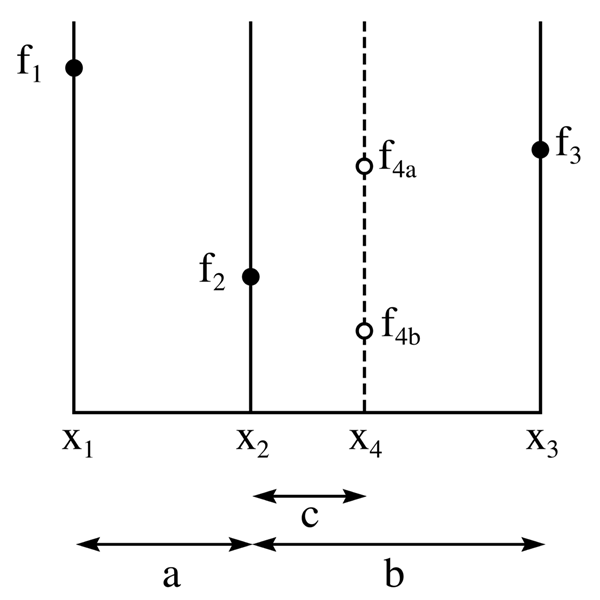

### The Golden ratio

To make a robust method, we want both of these paths to result in the same reduction of the search interval, and ideally reuse the function evaluations. This *self-similarity* implies we want to maintain the ratio of subdivision:

In the tripplet <$x_1, x_2, x_4$> with $f_{4a}$, we want, $\frac{c}{a}=\frac{a}{b}$.

In the tripplet <$x_2, x_4, x_3$> with $f_{4b}$, we want  $\frac{c}{b-c}=\frac{a}{b}$

Using these two equations, we can elimiante $c$ and find,
$${\frac{b}{a}}^2 - \frac{b}{a} = 1$$

and ignoring the negative root, $$\frac{b}{a} = \varphi = \frac{1+\sqrt{5}}{2} =1.618033988...$$

the *Golden ratio*!





#### Aside: The divine proportion

The Golden ratio appears **all over the place!**

In [ ]:
import numpy as np

def fibonacci(n):
  """
  Computes the Fibonacci sequence up to n terms.
  """
  fib_sequence = [0, 1]
  while len(fib_sequence) < n:
    next_fib = fib_sequence[-1] + fib_sequence[-2]
    fib_sequence.append(next_fib)
  return fib_sequence

n = 15  # Number of terms in the Fibonacci sequence
fib_sequence = fibonacci(n)
print("Fibonacci sequence:", fib_sequence)

golden_ratios = []
for i in range(2, n):
  golden_ratios.append(fib_sequence[i] / fib_sequence[i-1])

print("Golden ratios:", golden_ratios)

Fibonacci sequence: [0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377]
Golden ratios: [1.0, 2.0, 1.5, 1.6666666666666667, 1.6, 1.625, 1.6153846153846154, 1.619047619047619, 1.6176470588235294, 1.6181818181818182, 1.6179775280898876, 1.6180555555555556, 1.6180257510729614]


The Greeks knew it!

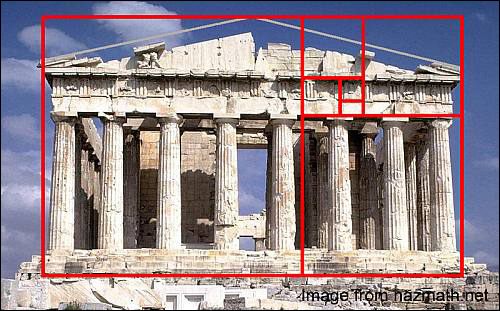

Nature knows it (kinda)

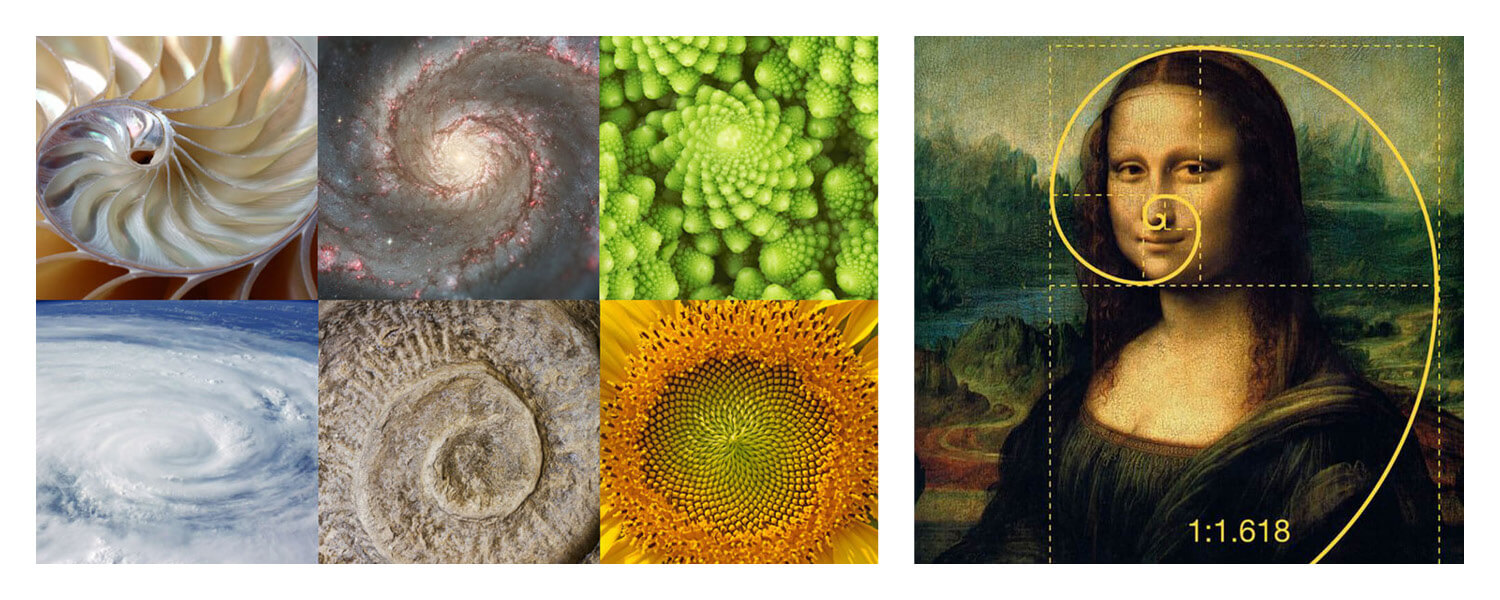

##Convergence rate

Each iteration of the Golden section method reduces the bracketed interval by $\varphi^{-1} = 0.618$, which becomes its order of convergence.

The Golden section method is gauranteed to converge but does so slowly at a sub-linear rate.



---


# Brent's method

We've seen this concept before in root finding with bisection. Later we saw the value of using the function values to approximate the derivative and guess at the root. Since we had two points, we fit a line (which approximated the derivative) which is the Secant method.


Now we have 3 points so we can fit a parabola and find $f_{min} = f(x_{min})$!




### Inverse quadratic interpolation

BUT there is one problem, we want to estimate $x_{min}$ not $f_{min}$, so what we actually need to approximate is the *inverse quadratic*.

$$
x_4 = \frac{f_2 f_3}{[f_1-f_2][f_1-f_3]} x_1 + \frac{f_1 f_3}{[f_2-f_1][f_2-f_3]} x_2 + \frac{f_3 f_2}{[f_3-f_1][f_3-f_2]} x_3
$$

The convergence order of inverse quadratic approxiation is $\sim 1.84$.



###Combination with Golden section

Brent's method combines the robutness of the Golden Section method with the accelaration of inverse quadratic approximation (still without any derivative information!).

Candidate steps from inverse quadratic interpolation, Golden section, and sometimes Secant, are generated and compared against various criteria for robustness and progression.

This complicated decision tree makes the order of convergence difficult to assess, but for well behaved functions it typically has $\gt 1.3$.

#### Example: Unimodal minimization

Minimize $x^4+10x$

[-5.         -4.8989899  -4.7979798  -4.6969697  -4.5959596  -4.49494949
 -4.39393939 -4.29292929 -4.19191919 -4.09090909 -3.98989899 -3.88888889
 -3.78787879 -3.68686869 -3.58585859 -3.48484848 -3.38383838 -3.28282828
 -3.18181818 -3.08080808 -2.97979798 -2.87878788 -2.77777778 -2.67676768
 -2.57575758 -2.47474747 -2.37373737 -2.27272727 -2.17171717 -2.07070707
 -1.96969697 -1.86868687 -1.76767677 -1.66666667 -1.56565657 -1.46464646
 -1.36363636 -1.26262626 -1.16161616 -1.06060606 -0.95959596 -0.85858586
 -0.75757576 -0.65656566 -0.55555556 -0.45454545 -0.35353535 -0.25252525
 -0.15151515 -0.05050505  0.05050505  0.15151515  0.25252525  0.35353535
  0.45454545  0.55555556  0.65656566  0.75757576  0.85858586  0.95959596
  1.06060606  1.16161616  1.26262626  1.36363636  1.46464646  1.56565657
  1.66666667  1.76767677  1.86868687  1.96969697  2.07070707  2.17171717
  2.27272727  2.37373737  2.47474747  2.57575758  2.67676768  2.77777778
  2.87878788  2.97979798  3.08080808  3.18181818  3

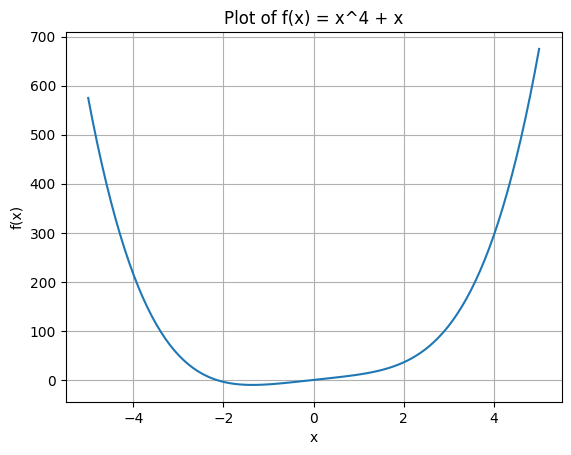

-5
0
5
-1.9098300000000001
-3.09016987422
-1.0343458767574745
-1.181577493941968
-1.304005930779925
-1.5354101272036402
-1.3493130244641753
-1.360162925456641
-1.3572686570310966
-1.357202998346505
-1.3572088473834198
-1.3572088082219729
-1.3572087881252826
Minimum found at x = -10.1790660622309
-1.3572088082219729
Minimum function value = -10.1790660622309


In [ ]:
# prompt: Plot and minimize x^4+x on the interval -5 5 using brents method

def f(x):
  print(x)
  return x**4 + 10*x

x = np.linspace(-5, 5, 100)
y = f(x)

plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Plot of f(x) = x^4 + x')
plt.grid(True)
plt.show()


result = optimize.minimize_scalar(f, bracket=(-5, 0, 5), method = "Brent")
print("Minimum found at x =", result.fun)
print("Minimum function value =", f(result.x))


#### Example: Non differentiable function

Let's try a non-differential function: $f(x) = \|x\|$:

In [ ]:
# prompt: Use minimize_scalar on a nondifferentiable function

def nondiff_func(x):
  print(x)
  return abs(x)

#~~ What should we use for the bracket? What happens if we use a different method?
bracket = (-5, 5)

##

result = optimize.minimize_scalar(nondiff_func, bracket=bracket, method="Brent")
print("Minimum found at x =", result.x)
print("Minimum function value =", nondiff_func(result.x))


-5
5
21.18034
11.180339748440002
1.1803399999999997
-1.1803397484400002
-2.0351634599791169e-07
6.288998898266019e-08
0.4508497873081514
0.07788236151205088
0.01345381387145999
0.002324054369767623
0.0004014354205322895
6.931111691218845e-05
1.193804613339047e-05
2.0270904619436587e-06
3.150147269686505e-07
1.926087441788894e-08
-3.182935454321158e-08
3.0662337662403348e-09
-2.8394285480784205e-09
-3.279242240095256e-10
5.0637275275494315e-11
1.2024926045433706e-09
1.8487990512897325e-10
-3.023893922134733e-11
-2.0238938773811033e-11
3.0613588511369835e-12
2.1233741344083055e-11
-6.938641194171126e-12
Minimum found at x = 3.0613588511369835e-12
3.0613588511369835e-12
Minimum function value = 3.0613588511369835e-12


#### Example: A more treacherous function

[-5.         -4.8989899  -4.7979798  -4.6969697  -4.5959596  -4.49494949
 -4.39393939 -4.29292929 -4.19191919 -4.09090909 -3.98989899 -3.88888889
 -3.78787879 -3.68686869 -3.58585859 -3.48484848 -3.38383838 -3.28282828
 -3.18181818 -3.08080808 -2.97979798 -2.87878788 -2.77777778 -2.67676768
 -2.57575758 -2.47474747 -2.37373737 -2.27272727 -2.17171717 -2.07070707
 -1.96969697 -1.86868687 -1.76767677 -1.66666667 -1.56565657 -1.46464646
 -1.36363636 -1.26262626 -1.16161616 -1.06060606 -0.95959596 -0.85858586
 -0.75757576 -0.65656566 -0.55555556 -0.45454545 -0.35353535 -0.25252525
 -0.15151515 -0.05050505  0.05050505  0.15151515  0.25252525  0.35353535
  0.45454545  0.55555556  0.65656566  0.75757576  0.85858586  0.95959596
  1.06060606  1.16161616  1.26262626  1.36363636  1.46464646  1.56565657
  1.66666667  1.76767677  1.86868687  1.96969697  2.07070707  2.17171717
  2.27272727  2.37373737  2.47474747  2.57575758  2.67676768  2.77777778
  2.87878788  2.97979798  3.08080808  3.18181818  3

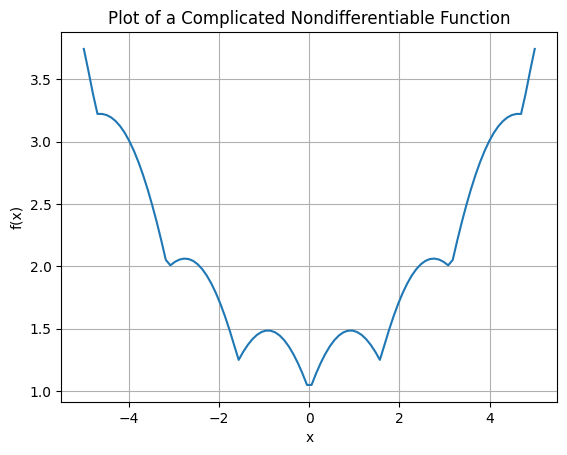

-5
5
21.18034
11.180339748440002
1.1803399999999997
0.09458844428123059
-1.851371125427094
-0.2178561188045674
0.2955773973951216
0.013367139936113784
-0.03125309331092177
0.00941889115377949
-0.0031614237350019517
-0.005118141940542849
0.0007171089314151327
0.004040893879762758
0.0001702967013971977
-0.0005786354954037355
2.4438122178259777e-05
-9.778851886602696e-05
1.3597865341453028e-05
-1.5788125925539715e-05
2.3734158011648776e-06
-4.6525327979423743e-07
-6.3180696527990555e-06
-7.928505706579973e-07
3.176832330622026e-07
1.102903179170109e-06
5.5181149917313e-08
-3.251689813735922e-08
-4.969018548934073e-08
5.638184896694283e-10
2.1425782105760735e-08
-2.724701120183268e-09
3.707823274770505e-09
1.9492149616025546e-10
-5.01574131468465e-10
-7.111615274257643e-11
-4.8692901721861595e-11
2.3219656378561172e-11
1.313591135533361e-11
-4.650324178731215e-12
-1.465032424755601e-11
Minimum found at x = -4.650324178731215e-12
-4.650324178731215e-12
Minimum function value = 1.00000000000

In [ ]:
# prompt: Plot and Do minimization on a more complicated nondifferentiable function

import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as optimize


def complicated_nondiff_func(x):
  print(x)
  return np.abs(np.sin(x)) + np.abs(np.cos(x))+.1*x**2


x = np.linspace(-5, 5, 100)
y = complicated_nondiff_func(x)

plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Plot of a Complicated Nondifferentiable Function')
plt.grid(True)
plt.show()

result = optimize.minimize_scalar(complicated_nondiff_func, bracket=(-5, 5), method="Brent")
print("Minimum found at x =", result.x)
print("Minimum function value =", complicated_nondiff_func(result.x))




---


# Powel's method

The easiest way to generalize to ND is to take our 1D methods and use them as a search routine (this should sound familiar!)

NB: We have moved beyond *bounds* which are a type of constraint. We are now into *unconstrained minimization*.




Powell's method uses a starting point and some initial direction vectors. The function is optimized along each direction vector.

Subsequent direction vectors are obtained through an important observation: The line connecting the results of the previous two searchs is directed towards the minimum (i.e.: It is conjugate to the other lines).

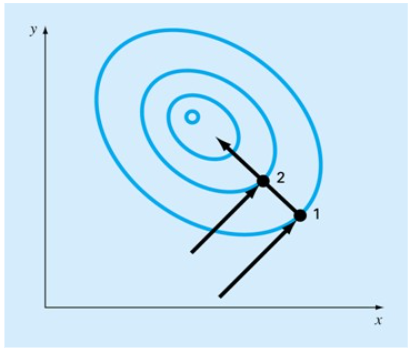

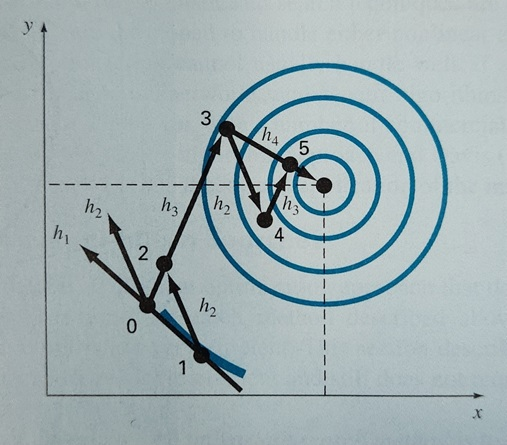

The algorithm is (Taken from Chapra and Canale - Numerical Methods for Engineers):
1. Start at 0 with directions $h_1$ and $h_2$
2. Search from 0 along $h_1$ to get to point 1.
3. Search from 1 along $h_2$ to get to 2.
4. Define $h_3$ from 0 to 2.
5. Search from 2 along $h_3$ to find 3
6. From 3, search along $h_2$ to get 4
7. From 4 search along $h_3$ to get 5.
8. Use points 5 and 3 to define $h_4$.
9. $h_3$ and $h_4$ are conjugate and therefore the solution can now be found as a combination of them.

Powell showed that this method generates conjugate directions *without needing to know anything about the function or its derivative*. Further, this method has quadratic convergence near the minimum!

#### Example: 2D optimization


In [ ]:
# prompt: Minimize a rosenbrock function with powels method, showing the guesses

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import plotly.graph_objects as go
import scipy.optimize as optimize

def rosenbrock(x):
  return ((1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2)

x0 = np.array([-1, 2.5])
result = optimize.minimize(rosenbrock, x0, method='Powell',options={'disp': True, 'return_all': True})
print('The minimum is, ', result.fun, ' found at ', result.x)
guesses = [x0]
for i in range(result.nit):
  guesses.append(result.allvecs[i])

x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 3, 100)
X, Y = np.meshgrid(x, y)
Z = rosenbrock([X, Y])

fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y)])
fig.update_layout(title='Rosenbrock Function', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

for guess in guesses:
  fig.add_trace(go.Scatter3d(
      x=[guess[0]], y=[guess[1]], z=[rosenbrock(guess)],
      mode='markers',
      marker=dict(
          size=5,
      )
  ))
fig.show()



Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 26
         Function evaluations: 684
The minimum is,  2.0830858278492343e-30  found at  [1. 1.]
